# Assignment 3

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
import datetime
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

### Load Data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

device = 'cpu'

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


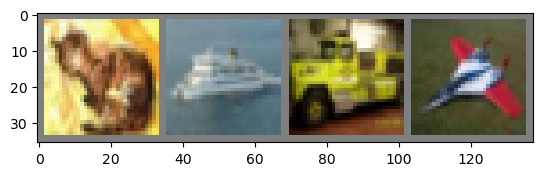

cat   ship  truck plane


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Setup Tensorboard and Network

In [4]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S") + "_" + "cpu")

writer = SummaryWriter(logdir)
writer.add_image('four images', torchvision.utils.make_grid(images))

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        #x = x.view(-1, 64 * 3 * 3)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
writer.add_graph(net, images)
#writer.close()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
# helper functions

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 4))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=False)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [9]:
def train(epoch):
    
    for epoch in range(epoch):  # loop over the dataset multiple times
    
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
        
            # zero the parameter gradients
            optimizer.zero_grad()
        
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                # ...log the running loss
                writer.add_scalar('training loss',
                            running_loss / 2000,
                            epoch * len(trainloader) + i)
    
                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
                running_loss = 0.0
    
    print('Finished Training')

### Run and test net on CPU

In [10]:
cpu_t_start = time.time()
train(2)
cpu_t_end = time.time()

writer.close()

[1,  2000] loss: 2.241
[1,  4000] loss: 1.980
[1,  6000] loss: 1.767
[1,  8000] loss: 1.612
[1, 10000] loss: 1.539
[1, 12000] loss: 1.453
[2,  2000] loss: 1.342
[2,  4000] loss: 1.291
[2,  6000] loss: 1.264
[2,  8000] loss: 1.196
[2, 10000] loss: 1.164
[2, 12000] loss: 1.119
Finished Training


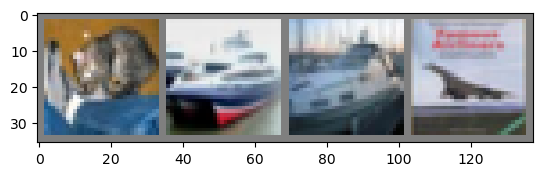

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                          for j in range(4)))

Predicted:  cat   ship  truck plane


In [14]:
def test(topk=False):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            if topk:
                _, predicted = torch.topk(outputs.data, 3)
                correct += predicted.eq(labels.view(-1,1).expand_as(predicted)).sum().item()
            else:    
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
            
            total += labels.size(0)
            
            #print(correct)
    
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Testing with highest output of net

In [15]:
test()

Accuracy of the network on the 10000 test images: 60 %


Testing with top 3 outputs of net

In [16]:
test(topk=True)

Accuracy of the network on the 10000 test images: 87 %


In [17]:
def category_test():
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    
    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    
    
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [18]:
category_test()

Accuracy for class: plane is 67.4 %
Accuracy for class: car   is 67.9 %
Accuracy for class: bird  is 35.5 %
Accuracy for class: cat   is 48.8 %
Accuracy for class: deer  is 52.8 %
Accuracy for class: dog   is 45.1 %
Accuracy for class: frog  is 77.5 %
Accuracy for class: horse is 57.8 %
Accuracy for class: ship  is 71.1 %
Accuracy for class: truck is 85.9 %


In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H:%M:%S") + "_" + "gpu")
writer = SummaryWriter(logdir)

print(device)

cuda:0


In [20]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=10, bias=True)
)

In [21]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

gpu_t_start = time.time() 
train(2)
gpu_t_end = time.time()

[1,  2000] loss: 2.270
[1,  4000] loss: 1.971
[1,  6000] loss: 1.764
[1,  8000] loss: 1.656
[1, 10000] loss: 1.552
[1, 12000] loss: 1.465
[2,  2000] loss: 1.370
[2,  4000] loss: 1.340
[2,  6000] loss: 1.286
[2,  8000] loss: 1.224
[2, 10000] loss: 1.171
[2, 12000] loss: 1.158
Finished Training


Testing with highest output of net

In [22]:
test()

Accuracy of the network on the 10000 test images: 60 %


Testing with top 3 outputs of net

In [23]:
test(topk=True)

Accuracy of the network on the 10000 test images: 88 %


In [24]:
print("Time CPU: " + str(cpu_t_end - cpu_t_start))
print("Time GPU: " + str(gpu_t_end - gpu_t_start))

Time CPU: 984.1689541339874
Time GPU: 1000.4415447711945


### Show five wrong classified images

In [25]:
def wrong_class_graph():
    number_of_false = 0
    wrong_imgs = []
    wrong_pred = []
    label = []
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            
            _, predicted = torch.topk(outputs.data, 3)
            
            correct = predicted.eq(labels.view(-1,1).expand_as(predicted))
            wrong_idx = (correct.sum(dim=1) == 0).nonzero(as_tuple=False).tolist()

            #print(wrong_idx)
            number_of_false += len(wrong_idx)
            for e in wrong_idx:
                wrong_imgs.append(images[e[0]])
                label.append(labels[e[0]])
                wrong_pred.append([predicted[e[0]][0].item(), predicted[e[0]][1].item(), predicted[e[0]][2].item()])

            if number_of_false >= 5:
                break

    fig = plt.figure(figsize=(12, 4))
    for idx in np.arange(5):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(wrong_imgs[idx].cpu(), one_channel=False)
        ax.set_title("{0}, \n(label: {1}\n{2}\n{3})".format(
            classes[label[idx]],
            classes[wrong_pred[idx][0]],
            classes[wrong_pred[idx][1]],
            classes[wrong_pred[idx][2]]))
    
    return fig

In [26]:
writer.add_figure('five wrong predictions', wrong_class_graph())
writer.close()

### Display Notebook

In [27]:
%load_ext tensorboard
%tensorboard --logdir logs

In [28]:
#notebook.display(port=6006, height=1000)